In [1]:
%matplotlib inline


# Kuka Reinforcement Learning (DQN)


This notebook shows how to train a Deep Q Learning (DQN) agent
on the pyBullet Kuka environment based on:
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

**Task**
The agent has to decide between seven (2+2+2+1) actions - moving the manipulator 
in $x$ (2), or $y$ (2) directions by vertical angle offset (2) or not moving at all (1) - so that the manipulator can grasp an object. We assume that the velocity for each directions equal and there is a "height hack" where the gripper automatically moves down for each action.

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, the reward is 1 if one of the objects is above height .2 at the end 
of the episode.

The pyBullet Kuka is designed so that the inputs to the agent are (48, 48, 3) images
representing the environment state.
Neural networks can solve the task purely by looking at the
scene, so we'll use stack of consecutive screens as an input. In this way, we are hoping to capture the dynamics of the environment.

**Packages**

First, let's import needed packages. Firstly, we need gym
(Install using `pip install gym`) and pyBullet (Install using `pip install pybullet`.
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).


Also for display the average reward and agent progress we are going to use tensorboarX (`pip install tensorboardX`.) To run tensorboard web server, you need to install it using `pip install tensorboard`.



In [2]:
%pip install pybullet
%pip install tensorboardX
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import collections
from itertools import count
import timeit
from datetime import timedelta
from PIL import Image
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from gym import spaces
import pybullet as p

env = KukaDiverseObjectEnv(renders=False, isDiscrete=True, removeHeightHack=False, maxSteps=20)
env.cid = p.connect(p.DIRECT)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
current_dir=/Users/ishankharat/anaconda3/envs/m3detr/lib/python3.10/site-packages/pybullet_envs/bullet


pybullet build time: Apr 30 2024 16:13:20


# Replay Memory


We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   consecutive stacked screens image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

# DQN algorithm


Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

## Q-network


Our model will be a convolutional neural network that takes in the
stacked screen patches. It has seven
outputs, representing $Q(s, d_x = d_v)$, $Q(s, d_x = -d_v)$, $Q(s, d_y = d_v)$, $Q(s, d_y = -d_v)$, $Q(s, d_a=0.25)$, 
and $Q(s, d_a=-0.25)$ (where $d_v=0.06$ is the velocity in PyBullet, $d_a$ is vertical angle offset for the gripper, and $s$ is the input to the
network). This discretization of action is based on the continuous action which is a 5-vector parameterizing XYZ offset, vertical angle offset (radians), and grasp angle (radians). The continuous action (5-vector) is discretized as follows with "height hack" where the gripper automatically moves down for each action, and grasp angle in PyBullet is set to 0.3:
```
        dx = [0, -dv, dv, 0, 0, 0, 0][action]
        dy = [0, 0, 0, -dv, dv, 0, 0][action]
        dz = -dv
        da = [0, 0, 0, 0, 0, -0.25, 0.25][action]
        
        action_continuous = [dx, dy, dz, da, 0.3]
```
In effect, the network is trying to predict the *expected return* of
taking each action given the current input. In order to capture the dynamics of the environment, we stack 5 consecutive screens of the environment after each step together and then feed them to the network.

In [4]:
STACK_SIZE = 5

In [5]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()  
        self.conv1 = nn.Conv2d(STACK_SIZE, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        self.linear = nn.Linear(linear_input_size, 512)
        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.linear(x.view(x.size(0), -1)))
        return self.head(x)

## Input extraction


The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




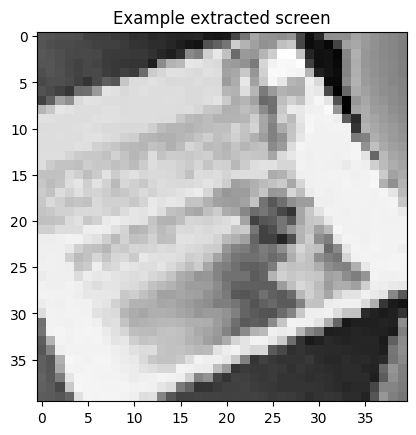

In [6]:
preprocess = T.Compose([T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

def get_screen():
    global stacked_screens
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return preprocess(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0)[-1].numpy(),cmap='Greys',
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Training


## Hyperparameters and utility function

This cell instantiates our model and its optimizer, and defines the
utility function:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.


In [7]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 200
EPS_DECAY_LAST_FRAME = 10**4
TARGET_UPDATE = 1000
LEARNING_RATE = 1e-4

# Get screen size so that we can initialize layers correctly based on shape
# returned from pybullet (48, 48, 3).  
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)


eps_threshold = 0

def select_action(state, i_episode):
    global steps_done
    global eps_threshold
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START - i_episode / EPS_DECAY_LAST_FRAME)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


# Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [8]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

In [9]:
PATH = 'policy_dqn.pt'

In [10]:
num_episodes = 10000000
writer = SummaryWriter()
total_rewards = []
ten_rewards = 0
best_mean_reward = None
start_time = timeit.default_timer()
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = get_screen()
    stacked_states = collections.deque(STACK_SIZE*[state],maxlen=STACK_SIZE)
    for t in count():
        stacked_states_t =  torch.cat(tuple(stacked_states),dim=1)
        # Select and perform an action
        action = select_action(stacked_states_t, i_episode)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        next_state = get_screen()
        if not done:
            next_stacked_states = stacked_states
            next_stacked_states.append(next_state)
            next_stacked_states_t =  torch.cat(tuple(next_stacked_states),dim=1)
        else:
            next_stacked_states_t = None
            
        # Store the transition in memory
        memory.push(stacked_states_t, action, next_stacked_states_t, reward)

        # Move to the next state
        stacked_states = next_stacked_states
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            reward = reward.cpu().numpy().item()
            ten_rewards += reward
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])*100
            writer.add_scalar("epsilon", eps_threshold, i_episode)
            if (best_mean_reward is None or best_mean_reward < mean_reward) and i_episode > 100:
                # For saving the model and possibly resuming training
                torch.save({
                        'policy_net_state_dict': policy_net.state_dict(),
                        'target_net_state_dict': target_net.state_dict(),
                        'optimizer_policy_net_state_dict': optimizer.state_dict()
                        }, PATH)
                if best_mean_reward is not None:
                    print("Best mean reward updated %.1f -> %.1f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            break
            
    if i_episode%10 == 0:
            writer.add_scalar('ten episodes average rewards', ten_rewards/10.0, i_episode)
            ten_rewards = 0
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if i_episode>=200 and mean_reward>50:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode+1, mean_reward))
        break


print('Average Score: {:.2f}'.format(mean_reward))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
writer.close()
env.close()

The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
The obtained block is green
Best mean reward updated 12.0 -> 13.0, model saved
The obtained block is green
Best mean reward updated 13.0 -> 14.0, model saved
The obtained block is green
Best mean reward updated 14.0 -> 15.0, model saved
The obt

KeyboardInterrupt: 